### Credit card Lead detection: Imabalanced Classification Problem
#### Analytics Vidhya Hackathon

In [141]:
#import files

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier

from sklearn.metrics import confusion_matrix,roc_auc_score, plot_confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV


from hyperopt import hp,fmin,tpe,Trials
from hyperopt.pyll.base import scope
from functools import partial

import warnings
warnings.filterwarnings(action='ignore')

In [142]:
#read file to dataframe

df = pd.read_csv('train_s3TEQDk.csv') 
df.head(2)

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,NNVBBKZB,Female,73,RG268,Other,X3,43,No,1045696,No,0
1,IDD62UNG,Female,30,RG277,Salaried,X1,32,No,581988,No,0


In [143]:
#load test data
df_test = pd.read_csv('test_mSzZ8RL.csv')
df_test.head(3)

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active
0,VBENBARO,Male,29,RG254,Other,X1,25,Yes,742366,No
1,CCMEWNKY,Male,43,RG268,Other,X2,49,NaN,925537,No
2,VK3KGA9M,Male,31,RG270,Salaried,X1,14,No,215949,No


### EDA

In [144]:
#check for null
def check_null_value(data):
    temp = 0
    for col in data.columns:
        if data[col].isnull().sum()>0:
            print('Columns - ',col,data[col].isnull().sum(),'Null present',round(data[col].isnull().sum()*100/len(data),2),'%')
            temp=1
    if temp == 0:
        print('There is no NULL')

In [145]:
#call function for checking NULL in train data

check_null_value(df)

Columns -  Credit_Product 29325 Null present 11.93 %


In [146]:
#call function for checking NULL in test data

check_null_value(df_test)

Columns -  Credit_Product 12522 Null present 11.89 %


#### OBSERVATION -
- <b>Only one field has NULL values

In [147]:
df.duplicated().sum()

0

#### OBSERVATION -
- <b> There is no duplicate value present in train data

In [148]:
#checking unique field
for col in df.columns:
    if len(df) == df[col].nunique():
        print ('{} is unique field'.format(col))

ID is unique field


- <b> As ID is unique field we'll remove it from processing 

#### Showing distribution of categorical fields

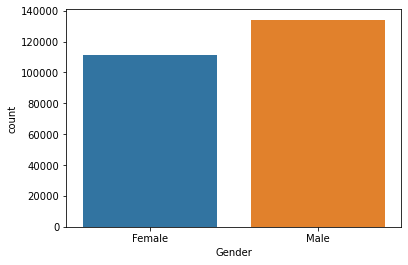

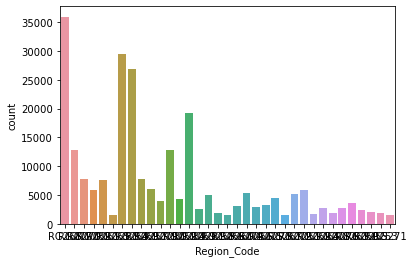

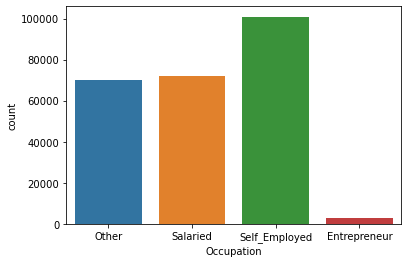

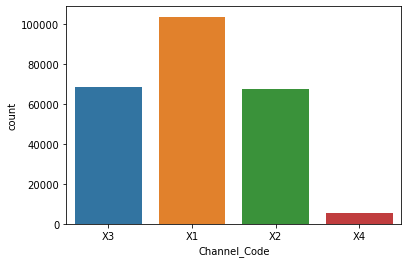

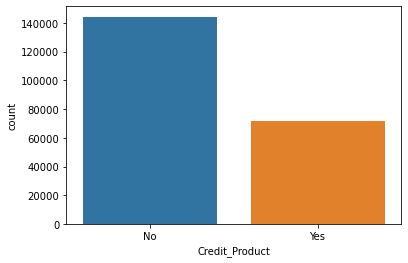

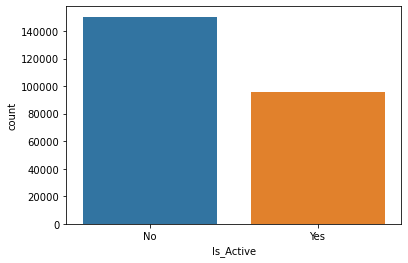

In [149]:
for col in df.columns:
    if df[col].dtype == 'O' and col!= 'ID':
        sns.countplot(df[col])
        plt.show()

#### Showing distribution of continuous field

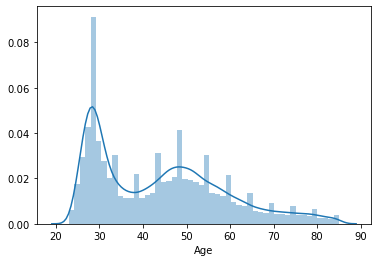

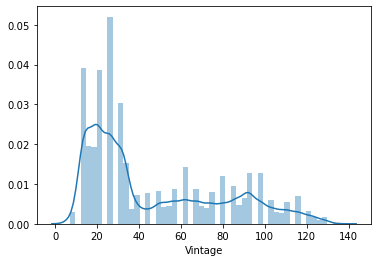

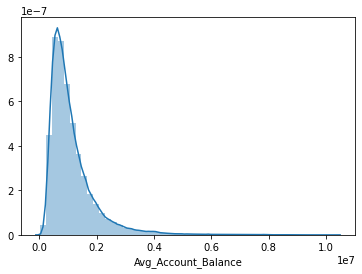

In [150]:
for col in df.columns:
    if df[col].dtype != 'O' and col !='Is_Lead':
        sns.distplot(df[col])
        plt.show()

#### Showing distribution of target

In [151]:
df['Is_Lead'].value_counts()

0    187437
1     58288
Name: Is_Lead, dtype: int64

- <b> Imbalanced Dataset

### Notes from EDA
- 1. This is an imbalanced dataset where target class is unevenly distributed
- 2. Categorical field Credit_Product has NULL which should be treated
- 3. Unique field ID should be removed

- 4. Categorical fields needs encoding

## Feature Engineering

#### ID is unique field so we are dropping it

- <B> ID removed from dataset

In [152]:
df.drop(['ID'],axis=1,inplace=True)

In [153]:
#storing ID for test data

test_data_id = df_test['ID']

In [154]:
df_test.drop(['ID'],axis=1,inplace=True)

<b> In the Train and Test data Credit_Product field's missing data will be filled with "Missing" string

In [155]:
df['Credit_Product'].value_counts()

No     144357
Yes     72043
Name: Credit_Product, dtype: int64

In [156]:
df['Credit_Product'].fillna('Missing',inplace=True)
df_test['Credit_Product'].fillna('Missing',inplace=True)

#### Frequency encode of Region_Code

In [157]:
def frequecy_encode():
    fields_to_encode = ['Region_Code','Occupation','Channel_Code']
    for col in fields_to_encode:
        dic_frequency = df[col].value_counts(normalize=True).to_dict()
        
        df[col] = df[col].map(dic_frequency)
        df_test[col] = df_test[col].map(dic_frequency)
        
#function called
frequecy_encode()

In [158]:
df.head()

,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,Female,73,0.146237,0.285575,0.27963,43,No,1045696,No,0
1,Female,30,0.052197,0.293006,0.42209,32,No,581988,No,0
2,Female,56,0.146237,0.410565,0.27963,26,No,1484315,Yes,0
3,Male,34,0.031417,0.293006,0.42209,19,No,470454,No,0
4,Female,30,0.023722,0.293006,0.42209,33,No,886787,No,0


#### Declaring function for feature transform

In [159]:
#function for categorical variable to dummy

def categorical_variable_dummy(data):
     cat_col = [col for col in data.columns if data[col].dtype == 'O']
     data = pd.get_dummies(data,columns=cat_col)  
     return data

In [160]:
#call function for dummy conversion

df = categorical_variable_dummy(df)
df_test = categorical_variable_dummy(df_test)

In [161]:
# df['Age'] = df['Age'] * 12
# df['account_balance_age_ratio'] = df['Avg_Account_Balance'] / df['Age']
# df['account_balance_vinatge_ratio'] = df['Avg_Account_Balance'] / df['Vintage']
# df['age_vinatge_ratio'] = df['Age'] / df['Vintage']

# df_test['Age'] = df_test['Age'] * 12
# df_test['account_balance_age_ratio'] = df_test['Avg_Account_Balance'] / df_test['Age']
# df_test['account_balance_vinatge_ratio'] = df_test['Avg_Account_Balance'] / df_test['Vintage']
# df_test['age_vinatge_ratio'] = df_test['Age'] / df_test['Vintage']

In [162]:
# df.head(3)

In [163]:
# df = pd.get_dummies(df,columns=['Age_binned','Vintage_binned','Avg_Account_Balance_binned'])
# df_test = pd.get_dummies(df_test,columns=['Age_binned','Vintage_binned','Avg_Account_Balance_binned'])

### Model processing

In [164]:
#split the data into X & y; label and feature component

X=df.drop(['Is_Lead'],axis=1) # create X or indepent variable set of the dataset
y=df['Is_Lead']               # create y or target variable

In [165]:
#split of train and validation set

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [166]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scale = ['Age','Vintage','Avg_Account_Balance']

In [167]:
X_train[scale] = scaler.fit_transform(X_train[scale])
X_test[scale] = scaler.transform(X_test[scale])
df_test[scale] = scaler.transform(df_test[scale])

In [104]:
X_train.head()

,Age,Region_Code,Occupation,Channel_Code,Vintage,Avg_Account_Balance,Gender_Female,Gender_Male,Credit_Product_Missing,Credit_Product_No,Credit_Product_Yes,Is_Active_No,Is_Active_Yes
138403,0.112903,0.013206,0.293006,0.27963,0.101562,0.163097,1,0,0,1,0,1,0
117015,0.516129,0.016181,0.410565,0.42209,0.234375,0.024960,1,0,0,1,0,1,0
322,0.161290,0.031063,0.293006,0.42209,0.046875,0.081589,1,0,0,1,0,1,0
64910,0.403226,0.146237,0.410565,0.27963,0.664062,0.114638,1,0,0,0,1,0,1
39919,0.129032,0.021512,0.285575,0.42209,0.093750,0.065166,1,0,0,1,0,1,0


### MachineLearning

#### Strategy
1. First I check the record on basis of default classifier - one bagging and one boosting
2. Parameter Optimization done and check accuracy
3. For imbalanced problem two other techniques have been used - move the threshold and use of resample techniques

### CatBoost

In [105]:
#catboost model applied and checked for roc_auc_score

cat_model = CatBoostClassifier()
cat_model.fit(X_train,y_train,silent=True)
pred_cat = cat_model.predict(X_test)
print('Confusion Metrics\n',confusion_matrix(y_test,pred_cat))
print('roc_auc_score\n',roc_auc_score(y_test,pred_cat))
print(classification_report(y_test,pred_cat))

Confusion Metrics
 [[53560  2700]
 [ 7688  9770]]
roc_auc_score
 0.7558186776392946
              precision    recall  f1-score   support

           0       0.87      0.95      0.91     56260
           1       0.78      0.56      0.65     17458

    accuracy                           0.86     73718
   macro avg       0.83      0.76      0.78     73718
weighted avg       0.85      0.86      0.85     73718



In [110]:
#important features

imp_feat=pd.Series(cat_model.feature_importances_,index=df.drop(['Is_Lead'],axis=1).columns) 
print(imp_feat.sort_values(ascending=False)[:5]) 

Credit_Product_Missing    23.847411
Occupation                23.494158
Age                       12.379469
Vintage                   10.553117
Credit_Product_Yes         6.967269
dtype: float64


### RandomForest

In [108]:
#randomforest model applied and checked for roc_auc_score

rf_model = RandomForestClassifier()
rf_model.fit(X_train,y_train)    
pred_rf = rf_model.predict(X_test)
print('Confusion Metrics\n',confusion_matrix(y_test,pred_rf))
print('roc_auc_score\n',roc_auc_score(y_test,pred_rf))
print(classification_report(y_test,pred_rf))

Confusion Metrics
 [[52776  3484]
 [ 7412 10046]]
roc_auc_score
 0.7567557129747624
              precision    recall  f1-score   support

           0       0.88      0.94      0.91     56260
           1       0.74      0.58      0.65     17458

    accuracy                           0.85     73718
   macro avg       0.81      0.76      0.78     73718
weighted avg       0.85      0.85      0.85     73718



In [109]:
#important features

imp_feat=pd.Series(rf_model.feature_importances_,index=df.drop(['Is_Lead'],axis=1).columns) 
print(imp_feat.sort_values(ascending=False)[:5]) 

Avg_Account_Balance       0.223555
Credit_Product_Missing    0.168907
Vintage                   0.147958
Age                       0.140127
Credit_Product_No         0.098367
dtype: float64


#### Show RF and Catboost confusion matrix

Randomforest


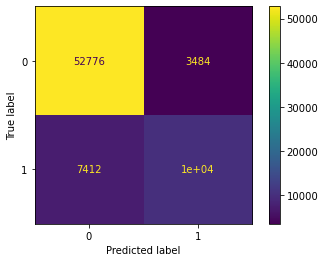

In [111]:
print('Randomforest')
plot_confusion_matrix(rf_model,X_test, y_test)
plt.show()

CatBoost


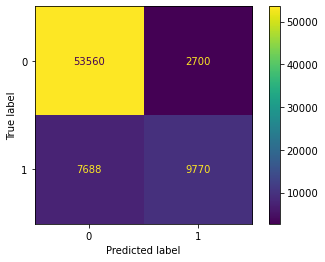

In [112]:
print('CatBoost')
plot_confusion_matrix(cat_model,X_test, y_test)
plt.show()

#### Optimal threshold detection using optimizer and threshold shifting to increase accuracy

I'll optimize the model, then extract prediction probability. After that, I'll shift the threshold in a grid to find the optimal threshold value where the prediction is most perfect

In [120]:
X = X_train.values
y = y_train.values

In [125]:
def optimize(params,x,y):
    
    model = RandomForestClassifier(**params)
    kf = model_selection.StratifiedKFold(n_splits=5)
    accuracies = []
    for idx in kf.split(X=x,y=y):
        train_idx, test_idx = idx[0],idx[1]
        xtrain = x[train_idx]
        ytrain = y[train_idx]
        
        xtest = x[test_idx]
        ytest = y[test_idx]
        
        model.fit(xtrain,ytrain)
        preds = model.predict(xtest)
        fold_acc = roc_auc_score(ytest,preds)
        accuracies.append(fold_acc)
    return -1.0 * np.mean(accuracies)

In [126]:
param_space = {
    'max_depth': scope.int(hp.quniform('max_depth',3,15,1)),
    'n_estimators': scope.int(hp.quniform('n_estimators',300,600,1)),
    'max_features': hp.uniform('max_features',0.01,1),
}

optimization_function = partial(optimize,x=X,y=y)

trials = Trials()

In [127]:
result = fmin(fn=optimization_function,
                    space=param_space,
                    algo=tpe.suggest,
                    max_evals = 10,
                    trials=trials)

100%|████████████████████████████████████████████| 10/10 [1:08:46<00:00, 412.69s/trial, best loss: -0.7555027503140342]


In [128]:
print(result)

{'max_depth': 13.0, 'max_features': 0.8761251293308258, 'n_estimators': 427.0}


In [129]:
rf_model = RandomForestClassifier(max_depth=13, max_features=0.8761251293308258, n_estimators=427)
rf_model.fit(X_train,y_train)   
rf_model.predict_proba(X_test) #probability of the class label

array([[0.95932745, 0.04067255],
       [0.93073312, 0.06926688],
       [0.86867087, 0.13132913],
       ...,
       [0.95680103, 0.04319897],
       [0.57843957, 0.42156043],
       [0.94882703, 0.05117297]])

In [130]:
#threshold shifting using prediction probability

step_factor = 0.05 
threshold_value = 0.2 
roc_score=0

predicted_proba = rf_model.predict_proba(X_test) #probability of prediction

while threshold_value <=0.8: #continue to check best threshold upto probability 0.8
    temp_thresh = threshold_value
    predicted = (predicted_proba [:,1] >= temp_thresh).astype('int') #change the class boundary for prediction
    print('Threshold',temp_thresh,'--',roc_auc_score(y_test, predicted))
    if roc_score<roc_auc_score(y_test, predicted): # 
        roc_score = roc_auc_score(y_test, predicted)
        thrsh_score = threshold_value
    threshold_value = threshold_value + step_factor
print('---Optimum Threshold ---',thrsh_score,'--ROC--',roc_score)  

Threshold 0.2 -- 0.7997196806946392
Threshold 0.25 -- 0.8022261084924881
Threshold 0.3 -- 0.7999717141463518
Threshold 0.35 -- 0.7947528855704353
Threshold 0.39999999999999997 -- 0.7832787497062168
Threshold 0.44999999999999996 -- 0.7702987316835811
Threshold 0.49999999999999994 -- 0.7527995318366435
Threshold 0.5499999999999999 -- 0.7380371802487974
Threshold 0.6 -- 0.7308087273964142
Threshold 0.65 -- 0.725927911818999
Threshold 0.7000000000000001 -- 0.7224702762329148
Threshold 0.7500000000000001 -- 0.715150174852636
---Optimum Threshold --- 0.25 --ROC-- 0.8022261084924881


#### The score increased from 0.75 to 0.8 if we can shift the probability threshold to 0.25

#### Upsampling techniques used for increasing accuracy

In [168]:
# create the training df by remerging X_train and y_train
df_train = X_train.join(y_train)

In [169]:
df_train['Is_Lead'].value_counts()

0    131177
1     40830
Name: Is_Lead, dtype: int64

In [171]:
from sklearn.utils import resample

#create two different dataframe of majority and minority class 

df_majority = df_train[(df_train['Is_Lead']==0)] 
df_minority = df_train[(df_train['Is_Lead']==1)] 

# upsample minority class

df_minority_upsampled = resample(df_minority, 
                                 replace=True,    # sample with replacement
                                 n_samples= 131177, # to match majority class
                                 random_state=42)  # reproducible results

# Combine minority class with downsampled majority class
df_upsampled = pd.concat([df_minority_upsampled, df_majority])

# Display new class counts
df_upsampled['Is_Lead'].value_counts()

1    131177
0    131177
Name: Is_Lead, dtype: int64

In [172]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train,y_train)    
pred_rf = rf_model.predict(X_test)
print('Confusion Metrics\n',confusion_matrix(y_test,pred_rf))
print('roc_auc_score\n',roc_auc_score(y_test,pred_rf))
print(classification_report(y_test,pred_rf))

Confusion Metrics
 [[52794  3466]
 [ 7471  9987]]
roc_auc_score
 0.7552259148023001
              precision    recall  f1-score   support

           0       0.88      0.94      0.91     56260
           1       0.74      0.57      0.65     17458

    accuracy                           0.85     73718
   macro avg       0.81      0.76      0.78     73718
weighted avg       0.84      0.85      0.84     73718



### From example it can be found that threshold shifting is the most optimal step to increase the accuracy

### Final prediction

In [ ]:
#final predicted dataframe

# final_pred = lgb_model.predict(df_test)
# final_df = pd.DataFrame({'ID':test_data_id,'Is_Lead':final_pred})
# final_df.to_csv('Submission.csv',index=None)